# chapter 3. 자녀와 엄마의 IQ 상관관계 분석

# INDEX(목차)
```
1. 데이터 살펴보기
2. 데이터 스펙 체크
3. 문제해결 프로세스 정의
ch 1. Data Preprocessing
ch 2. EDA
ch 3. Cross validation
```

In [1]:
import warnings
warnings.filterwarnings('ignore')

## 1. 문제 및 데이터 살펴보기
```
부모는 자녀의 IQ에 큰 관심을 가진다.
결혼을 하지 않는 사람들도 자신의 미래의 자녀들의 IQ를 궁금해한다.
데이터를 통해 자녀의 IQ와 부모의 IQ의 상관관계를 알 수 있을까?
```
|Column|Description|
|:---|:---|
|kid_score|아이의 시험 점수|
|mom_hs|엄마의 학력|
|mom_iq|엄마의 IQ|
|mom_work|엄마의 일하는 시간|
|mom_age|엄마의 나이|

In [2]:
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

kid_iq = pd.read_csv('Data/kidiq.csv')
kid_iq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27


## 2. 데이터 스펙
<img src = "https://drive.google.com/file/d/1UT-ul9cp0kd_S3dewyOhR3iQfDB6758Y/view?usp=drive_link">

1. feature 변형 : 모델링에 편차를 반영하기 위해 각 컬럼 값에 컬럼 값의 평균을 빼는 변형 실습 진행
2. 데이터 분할 : 일반 val과 Cross val 실습을 위해 데이터를 2등분, 5등분하는 데이터 분할 실습 진행
- 데이터 증강 작업은 진행하지 않습니다.

```
row 변화 : 434 -> 434
col 변화 : 5 -> 7
```

## 3. 프로세스 정의
```
* 문제정의
아이의 IQ와 엄마의 IQ에 대한 관심이 높아졌다. 진짜로 관련이 있는지 알아보자!

* 기대효과
관련이 있다면, 연구에 활용할 수 있는 정보가 될 수 있다.

* 해결방안
OLS를 이용한 Regression 방법 적용
part 1. Feature Engineering, OLS regression
part 2. Data Visualization
part 3. K-fold cross validation (statsmodels), K-fold cross validation (scikit-leran)
```

### ch 1. Data Preprocessing

In [3]:
# import package
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# 통계 모형을 설명하고 설계 행렬을 구축, statsmodels와 사용
import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [4]:
kid_iq.shape

(434, 5)

In [5]:
kid_iq.info()

# 결측치 존재 X

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   kid_score  434 non-null    int64  
 1   mom_hs     434 non-null    int64  
 2   mom_iq     434 non-null    float64
 3   mom_work   434 non-null    int64  
 4   mom_age    434 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 17.1 KB


In [6]:
kid_iq.describe()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
count,434.000000,434.000000,434.000000,434.000000,434.000000
mean,86.797235,0.785714,100.000000,2.896313,22.785714
std,20.410688,0.410799,15.000000,1.181394,2.701070
min,20.000000,0.000000,71.037405,1.000000,17.000000
25%,74.000000,1.000000,88.660321,2.000000,21.000000
50%,90.000000,1.000000,97.915254,3.000000,23.000000
75%,102.000000,1.000000,110.272742,4.000000,25.000000
max,144.000000,1.000000,138.893106,4.000000,29.000000


In [7]:
# 추가 feature 생성
kid_iq['mom_iq_d'] = kid_iq['mom_iq'] - kid_iq['mom_iq'].mean()
kid_iq['mom_age_d'] = kid_iq['mom_age'] - kid_iq['mom_age'].mean()
kid_iq

,kid_score,mom_hs,mom_iq,mom_work,mom_age,mom_iq_d,mom_age_d
0,65,1,121.117529,4,27,21.117529,4.214286
1,98,1,89.361882,4,25,-10.638118,2.214286
2,85,1,115.443165,4,27,15.443165,4.214286
3,83,1,99.449639,3,25,-0.550361,2.214286
4,115,1,92.745710,4,27,-7.254290,4.214286
...,...,...,...,...,...,...,...
429,94,0,84.877412,4,21,-15.122588,-1.785714
430,76,1,92.990392,4,23,-7.009608,0.214286
431,50,0,94.859708,2,24,-5.140292,1.214286
432,88,1,96.856624,2,21,-3.143376,-1.785714


array([[<Axes: title={'center': 'kid_score'}>,
        <Axes: title={'center': 'mom_hs'}>,
        <Axes: title={'center': 'mom_iq'}>],
       [<Axes: title={'center': 'mom_work'}>,
        <Axes: title={'center': 'mom_age'}>,
        <Axes: title={'center': 'mom_iq_d'}>],
       [<Axes: title={'center': 'mom_age_d'}>, <Axes: >, <Axes: >]],
      dtype=object)

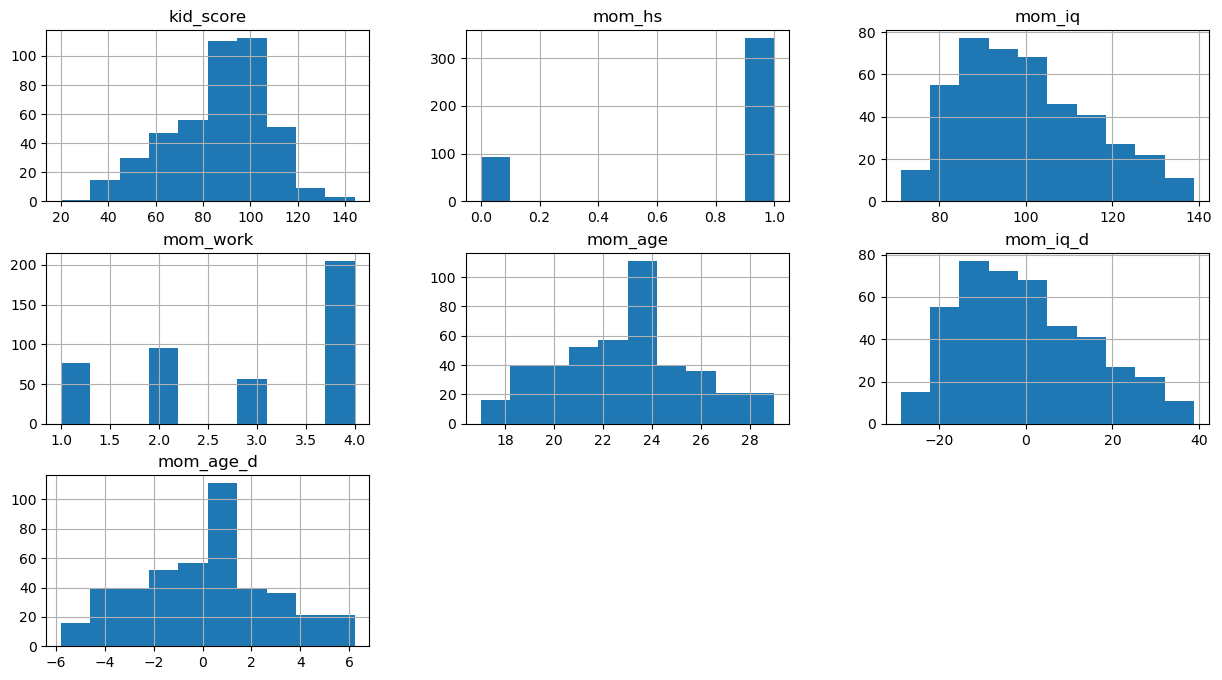

In [8]:
# histogram visualization
kid_iq.hist(figsize=(15,8))

### ch 2. Data Visualization

In [9]:
# OLS: Ordinary Least Sqaures
# 에러의 제곱합을 최소화하는 가중치 벡터를 구하는 방법
fit1 = smf.ols('kid_score ~ 1 + mom_hs + mom_iq_d + mom_age_d', data=kid_iq).fit()

print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     39.25
Date:                Sat, 01 Jun 2024   Prob (F-statistic):           1.94e-22
Time:                        16:17:12   Log-Likelihood:                -1871.8
No. Observations:                 434   AIC:                             3752.
Df Residuals:                     430   BIC:                             3768.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     82.3602      1.976     41.676      0.0

* coef(계수)을 살펴보자
* R-squared

In [10]:
y = kid_iq['kid_score']
X = kid_iq[['mom_hs', 'mom_iq_d', 'mom_age_d']]
X = sm.add_constant(X) # 상수항 1 추가

# OLS: 종속 변수와 한 개 이상의 독립 변수 간의 관계를 모델링
model1 = sm.OLS(y,X)

# 모델 학습
res1 = model1.fit()

# 모델 요약
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     39.25
Date:                Sat, 01 Jun 2024   Prob (F-statistic):           1.94e-22
Time:                        16:17:12   Log-Likelihood:                -1871.8
No. Observations:                 434   AIC:                             3752.
Df Residuals:                     430   BIC:                             3768.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.3602      1.976     41.676      0.0

* 위 코드와 비교해본결과, 똑같은 summary

In [11]:
# 각 독립변수의 항을 features 객체에 저장
features = res1.params.index

# 각 독립변수의 계수를 coefs 객체에 저장
coefs = [round(val, 3) for val in res1.params.values]

# 사전으로 만듦
dict(zip(features, coefs))

{'const': 82.36, 'mom_hs': 5.647, 'mom_iq_d': 0.563, 'mom_age_d': 0.225}

In [12]:
# R-sqaured 값
print("R-squared: %.3f" % round(res1.rsquared, 3))

R-squared: 0.215


In [13]:
# RMSE 값
print("RMSE: %.3f" % round(np.mean((y - res1.fittedvalues)**2)**0.5, 3))

RMSE: 18.063


In [14]:
def abline(intercept, slope, **params):
    axes = plt.gca() # 축
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', **params)

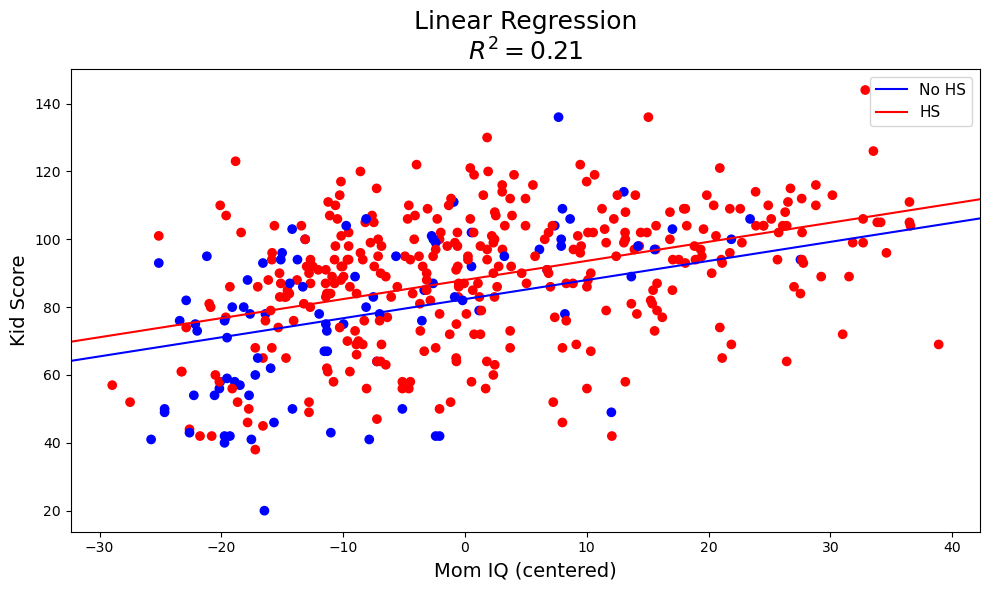

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {1:'red', 0:'blue'}
b_hat = fit1.params
ax.scatter(kid_iq.mom_iq_d, kid_iq.kid_score, color=kid_iq.mom_hs.map(colors))

sm.graphics.abline_plot(intercept=b_hat['Intercept'],                 slope=b_hat['mom_iq_d'], color='blue',  label='No HS', ax=ax)
sm.graphics.abline_plot(intercept=b_hat['Intercept']+b_hat['mom_hs'], slope=b_hat['mom_iq_d'], color='red', label='HS',    ax=ax)
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ (centered)', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % fit1.rsquared_adj, fontsize=18)

fig.tight_layout();

### ch 3. Cross Validation

#### K-fold Cross Validation using by statsmodels and scikit-learn

In [16]:
len(y), round(len(y)*(4/5))

(434, 347)

In [17]:
y = kid_iq['kid_score']
X = kid_iq[['mom_hs', 'mom_iq_d']]
X = sm.add_constant(X)

In [18]:
# R-squared
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
scores = []

for k, (train, test) in enumerate(kfold.split(X,y)):
    model1 = sm.OLS(y[train], X.loc[train,:])
    res1 = model1.fit()
    preds = res1.predict(X.loc[test,:])
    score = r2_score(y[test], preds)
    scores.append(score)
    print('Fold: {:2d}, Train Size: {}, R-squared: {:.3f}'.format(k+1, len(y[train]), score))

print('\nCV R-squared: {:.3f}, STD: {:.3f}'.format(np.mean(scores), np.std(scores)))

Fold:  1, Train Size: 347, R-squared: 0.205
Fold:  2, Train Size: 347, R-squared: 0.070
Fold:  3, Train Size: 347, R-squared: 0.302
Fold:  4, Train Size: 347, R-squared: 0.137
Fold:  5, Train Size: 348, R-squared: 0.264

CV R-squared: 0.196, STD: 0.084


In [19]:
y = kid_iq['kid_score']
X = kid_iq[['mom_hs', 'mom_iq_d']]
X = sm.add_constant(X)

In [20]:
# RMSE
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

scores = []
for k, (train, test) in enumerate(kfold.split(X,y)):
    model1 = sm.OLS(y[train], X.loc[train,:])
    res1 = model1.fit()
    preds = res1.predict(X.loc[test,:])
    score = mean_squared_error(y[test], preds, squared=False)
    scores.append(score)
    print('Fold: {:2d}, Train Size: {}, RMSE: {:.3f}'.format(k+1, len(y[train]), score))

print('\nCV RMSE: {:.3f}, STD: {:.3f}'.format(np.mean(scores), np.std(scores)))

Fold:  1, Train Size: 347, RMSE: 18.394
Fold:  2, Train Size: 347, RMSE: 18.640
Fold:  3, Train Size: 347, RMSE: 17.431
Fold:  4, Train Size: 347, RMSE: 18.849
Fold:  5, Train Size: 348, RMSE: 17.594

CV RMSE: 18.182, STD: 0.567


#### 새로운 feature를 생성 후, 5-fold Cross Validation

In [21]:
# create 'mom_hs_iq_d' feature 
kid_iq['mom_hs_iq_d'] = kid_iq['mom_hs'] * kid_iq['mom_iq_d']

y = kid_iq['kid_score']
X = kid_iq[['mom_hs', 'mom_iq_d', 'mom_hs_iq_d']]
X = sm.add_constant(X)
X

,const,mom_hs,mom_iq_d,mom_hs_iq_d
0,1.0,1,21.117529,21.117529
1,1.0,1,-10.638118,-10.638118
2,1.0,1,15.443165,15.443165
3,1.0,1,-0.550361,-0.550361
4,1.0,1,-7.254290,-7.254290
...,...,...,...,...
429,1.0,0,-15.122588,-0.000000
430,1.0,1,-7.009608,-7.009608
431,1.0,0,-5.140292,-0.000000
432,1.0,1,-3.143376,-3.143376


In [22]:
# R-squared
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
scores = []

for k, (train, test) in enumerate(kfold.split(X,y)):
    model1 = sm.OLS(y[train], X.loc[train,:])
    res1 = model1.fit()
    preds = res1.predict(X.loc[test,:])
    score = r2_score(y[test], preds)
    scores.append(score)
    print('Fold: {:2d}, Train Size: {}, R-squared: {:.3f}'.format(k+1, len(y[train]), score))

print('\nCV R-squared: {:.3f}, STD: {:.3f}'.format(np.mean(scores), np.std(scores)))

Fold:  1, Train Size: 347, R-squared: 0.224
Fold:  2, Train Size: 347, R-squared: 0.103
Fold:  3, Train Size: 347, R-squared: 0.322
Fold:  4, Train Size: 347, R-squared: 0.103
Fold:  5, Train Size: 348, R-squared: 0.290

CV R-squared: 0.208, STD: 0.092


In [23]:
# 10-fold Cross Validation RMSE
kfold = KFold(n_splits=10, shuffle=True, random_state=123)

scores = []
for k, (train, test) in enumerate(kfold.split(X,y)):
    model1 = sm.OLS(y[train], X.loc[train,:])
    res1 = model1.fit()
    preds = res1.predict(X.loc[test,:])
    score = mean_squared_error(y[test], preds, squared=False)
    scores.append(score)
    print('Fold: {:2d}, Train Size: {}, RMSE: {:.3f}'.format(k+1, len(y[train]), score))

print('\nCV RMSE: {:.3f}, STD: {:.3f}'.format(np.mean(scores), np.std(scores)))

Fold:  1, Train Size: 390, RMSE: 18.557
Fold:  2, Train Size: 390, RMSE: 17.975
Fold:  3, Train Size: 390, RMSE: 19.506
Fold:  4, Train Size: 390, RMSE: 16.829
Fold:  5, Train Size: 391, RMSE: 18.527
Fold:  6, Train Size: 391, RMSE: 16.476
Fold:  7, Train Size: 391, RMSE: 20.745
Fold:  8, Train Size: 391, RMSE: 16.658
Fold:  9, Train Size: 391, RMSE: 17.683
Fold: 10, Train Size: 391, RMSE: 17.010

CV RMSE: 17.997, STD: 1.302


* R-squared 값: 0.196 -> 0.208 (클수록 좋음)
* RMSE 값: 18.182 -> 17.997 (작을수록 좋음)

#### K-fold Cross Validation "by hand"

In [24]:
y = kid_iq['kid_score'].values # ndarray
X = kid_iq[['mom_hs', 'mom_iq_d']]
X = sm.add_constant(X)
X = X.values # ndarray

In [25]:
# R-squared

n_samples = len(y) # 434
indices = np.arange(n_samples)
n_splits = 5
num_val_samples = np.full(n_splits, n_samples // n_splits, dtype=int)
num_val_samples[: n_samples%n_splits] += 1

scores = []
for i in range(n_splits): # 0 1 2 3 4
    start = i * num_val_samples[i]
    stop = (i+1) * num_val_samples[i]
    y_test = y[indices[start:stop]]
    X_test = X[indices[start:stop], :]
    y_train = np.concatenate([ y[indices[:start]], y[indices[stop:]]], axis=0)
    X_train = np.concatenate([ X[indices[:start], :], X[indices[stop:], :]], axis=0)
    
    # modeling
    model1 = sm.OLS(y_train, X_train)
    res1 = model1.fit()
    score = res1.rsquared
    scores.append(score)
    print('Fold: {:2d}, Train size: {}, R-sqaured: {:.3f}'.format(i+1, len(y_train), score))

print('R-squared: {:.3f}, STD: {:.3f}'.format(np.mean(scores), np.std(scores)))

Fold:  1, Train size: 347, R-sqaured: 0.252
Fold:  2, Train size: 347, R-sqaured: 0.185
Fold:  3, Train size: 347, R-sqaured: 0.205
Fold:  4, Train size: 347, R-sqaured: 0.196
Fold:  5, Train size: 348, R-sqaured: 0.228
R-squared: 0.213, STD: 0.024


In [26]:
# RMSE
y = kid_iq['kid_score'].values
X = kid_iq[['mom_hs', 'mom_iq_d']]
X = sm.add_constant(X)
X = X.values

n_samples = len(y)
indices = np.arange(n_samples)

n_splits = 5
num_val_samples = np.full(n_splits, n_samples // n_splits, dtype=int)
num_val_samples[: n_samples % n_splits] += 1

scores = []
for i in range(n_splits):
    start =  i      * num_val_samples[i]
    stop  = (i + 1) * num_val_samples[i]
    y_test = y[indices[start:stop]]
    X_test = X[indices[start:stop], :]
    y_train = np.concatenate([ y[indices[:start]] , 
                               y[indices[stop:]] ] , axis=0)
    X_train = np.concatenate([ X[indices[:start], :] , 
                               X[indices[stop:], :] ] , axis=0)

    res1 = sm.OLS(y_train, X_train).fit()
    preds = res1.predict(X_test)
    score = np.mean((y_test - preds)**2)**0.5
    scores.append(score)
    print('Fold: {:2d}, Training size: {}, RMSE: {:.3f}'.format(i+1, len(y_train), score))

print('\nCV RMSE: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores)))

Fold:  1, Training size: 347, RMSE: 18.242
Fold:  2, Training size: 347, RMSE: 17.234
Fold:  3, Training size: 347, RMSE: 15.566
Fold:  4, Training size: 347, RMSE: 23.994
Fold:  5, Training size: 348, RMSE: 18.744

CV RMSE: 18.756 (+/- 2.835)


#### scikit-learn

In [27]:
y = kid_iq['kid_score']
X = kid_iq[['mom_hs', 'mom_iq_d']]

# 모델 생성 및 학습
model1 = LinearRegression()
lm1 = model1.fit(X,y)

# coef(계수), features
coefs = [round(val, 3) for val in list(np.concatenate((lm1.intercept_, lm1.coef_),axis=None))]
features = list(np.concatenate((np.array('Intercept'), lm1.feature_names_in_), axis=None))

dict(zip(features, coefs))

{'Intercept': 82.122, 'mom_hs': 5.95, 'mom_iq_d': 0.564}

In [28]:
# R-squared
print("R-squared: %.3f" % round(lm1.score(X,y), 3))

R-squared: 0.214


In [29]:
# RMSE
print("RMSE: %.3f" % round(mean_squared_error(y, lm1.predict(X), squared=False), 3))

RMSE: 18.073


#### Cross Validation using scikit-learn

In [37]:
# R-squared
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
scores = []

for k, (train, test) in enumerate(kfold.split(X,y)):
    lm1.fit(X.loc[train,:], y[train])
    score = lm1.score(X.loc[test,:], y[test])
    scores.append(score)
    print('Fold: {:2d}, Train size: {}, R-squared: {:.3f}'.format(k+1, len(y[train]), score))
print('R-squared: {:.3f} STD: {:.3f}'.format(np.mean(scores), np.std(scores)))

Fold:  1, Train size: 347, R-squared: 0.205
Fold:  2, Train size: 347, R-squared: 0.070
Fold:  3, Train size: 347, R-squared: 0.302
Fold:  4, Train size: 347, R-squared: 0.137
Fold:  5, Train size: 348, R-squared: 0.264
R-squared: 0.196 STD: 0.084


In [38]:
# RMSE
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
scores = []

for k, (train, test) in enumerate(kfold.split(X, y)):
    lm1.fit(X.loc[train,:], y[train])
    preds = lm1.predict(X.loc[test,:])
    score = mean_squared_error(y[test], preds, squared=False)
    scores.append(score)
    print('Fold: {:2d}, Training size: {}, Out-of-sample RMSE: {:.3f}'.format(k+1, len(y[train]), score))
    
print('\nCV RMSE: {:.3f} (+/- {:.3f})'.format(np.mean(scores), np.std(scores, ddof=1) * 2))

Fold:  1, Training size: 347, Out-of-sample RMSE: 18.394
Fold:  2, Training size: 347, Out-of-sample RMSE: 18.640
Fold:  3, Training size: 347, Out-of-sample RMSE: 17.431
Fold:  4, Training size: 347, Out-of-sample RMSE: 18.849
Fold:  5, Training size: 348, Out-of-sample RMSE: 17.594

CV RMSE: 18.182 (+/- 1.268)


#### Summary
```
* Cross Validation은 언제 유의미하게 사용될까?
1. 데이터 크기가 매우 커서 나눠지는 데이터의 분포를 담보할 수 없을 때
2. 모델의 복잡도가 매우 높아서 데이터의 특성에 따라 결과가 바뀔 때
3. 거의 대부분

* Cross Validation의 결과에서 특정 Fold에서만 결과가 잘 나오는 경우, 배포는 어떻게 하면 될까?
(5-fold CV에서 1번, 3번의 fold에서만 결과가 잘 나오고, 2,4,5번의 fold에서는 결과가 잘 나오지 않을 때는 어떻게 할까?)
1. 보톹, 결과는 모든 fold를 정리하고 가장 결과가 좋은 데이터를 활용한 모델의 weight를 이용하여 최종 모델 생성
2. 2,4,5번의 fold의 데이터를 별개로 분석 -> 해당 데이터셋에서 결과가 낮게 나오는 이유를 분석하여 모델링 특성에 반영
```